
Basic Kaggle Imports
---




In [124]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as pyplot
import pickle
from matplotlib import style
from google.colab import drive
from collections import Counter
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [30]:
drive.mount('/content/drive')
nltk.download('stopwords')
nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## EDA

In [11]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab/data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab/data/test.csv')

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   text_length                                       Cleaned_Text  
0         1866  worldcom exboss launch defence lawyer defendin...  
1         2016  german business confidence slide german busine...  
2         3104  bbc poll indicates economic gloom citizen majo...  
3         3618  lifestyle governs mobile choice faster better ...  
4         2190  enron boss payout eighteen former enron direct...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column        Non-

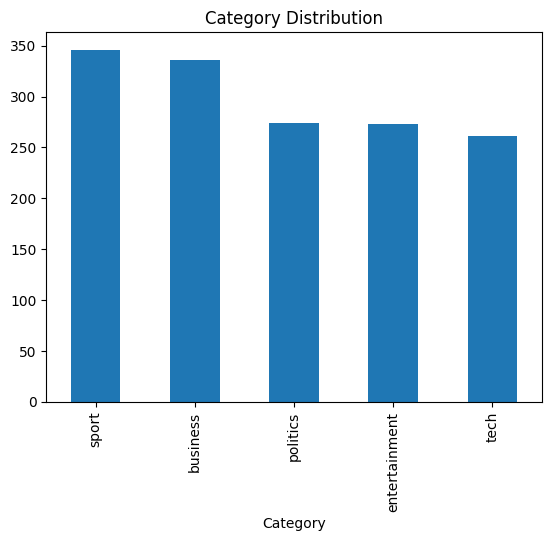

In [57]:
#Basic train data info
print(train_data.head())
print(train_data.info())
print(train_data.describe())

print(train_data.isnull().sum())

if 'Category' in train_data.columns:
    train_data['Category'].value_counts().plot(kind='bar', title='Category Distribution')

Brief info on the data, gathering size, nulls, types of categories and size of each, etc. This just helps me understand the shape of the data if any debugging is necessary.


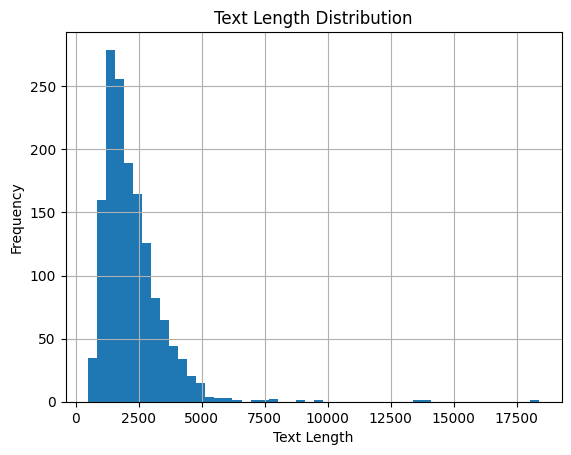

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('the', 34992), ('to', 16568), ('of', 12970), ('and', 12366), ('a', 12102), ('in', 11696), ('s', 5899), ('for', 5773), ('is', 5478), ('that', 5207)]


In [13]:
train_data['text_length'] = train_data['Text'].apply(len)

# Histogram of text lengths
import matplotlib.pyplot as plt
train_data['text_length'].hist(bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Word frequency (top 10 most common words)
from collections import Counter
import nltk
nltk.download('punkt')

# Tokenize and count words
all_words = ' '.join(train_data['Text']).split()
word_freq = Counter(all_words)
print(word_freq.most_common(10))

In [16]:
# Tokenize and count words in the entire dataset
nltk.download('punkt')  # Ensure tokenizer is available
all_words = ' '.join(train_data['Text']).lower().split()  # Convert to lowercase and split into words

# Count word frequencies
word_freq = Counter(all_words)

# Convert to a DataFrame for better visualization
word_freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

# Display the ranked list
print(word_freq_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


    Word  Frequency
0    the      34992
1     to      16568
2     of      12970
3    and      12366
4      a      12102
5     in      11696
6      s       5899
7    for       5773
8     is       5478
9   that       5207
10    it       5000
11    on       4991
12   was       4019
13    he       3866
14    be       3803
15  with       3482
16  said       3401
17   has       3250
18    as       3245
19  have       3133


The histogram is the count of word length and the list is the most common words. This is simply used before pre-processing to figure out what aspects of the `re` class I will be using

## Data Cleaning

In [35]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join back into a single string
    return ' '.join(words)

# Apply cleaning to the dataset
train_data['Cleaned_Text'] = train_data['Text'].apply(clean_text)
print(train_data[['Text', 'Cleaned_Text']].head())

                                                Text  \
0  worldcom ex-boss launches defence lawyers defe...   
1  german business confidence slides german busin...   
2  bbc poll indicates economic gloom citizens in ...   
3  lifestyle  governs mobile choice  faster  bett...   
4  enron bosses in $168m payout eighteen former e...   

                                        Cleaned_Text  
0  worldcom exboss launch defence lawyer defendin...  
1  german business confidence slide german busine...  
2  bbc poll indicates economic gloom citizen majo...  
3  lifestyle governs mobile choice faster better ...  
4  enron boss payout eighteen former enron direct...  


In [36]:
for i in range(3):  # Display first 3 examples
    print(f"Original: {train_data['Text'].iloc[i]}")
    print(f"Cleaned: {train_data['Cleaned_Text'].iloc[i]}")
    print("-" * 100)

Original: worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldco

Data cleaning, using the `re` python class to remove and special characters, stopwords, and to tokenize the sentences (words to values)

## Building the Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(train_data['Cleaned_Text'])

n_topics = 5
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X)  # The document-topic matrix
H = nmf.components_  # The topic-word matrix

print("W shape (Document-Topic matrix):", W.shape)
print("H shape (Topic-Word matrix):", H.shape)

# Check the top words for each topic
terms = vectorizer.get_feature_names_out()

for i, topic in enumerate(H):
    print(f"\nTopic {i+1}:")
    top_words_idx = topic.argsort()[-10:][::-1]  # Get indices of the top 10 words for each topic
    top_words = [terms[idx] for idx in top_words_idx]
    print("Top words:", ", ".join(top_words))

W shape (Document-Topic matrix): (1490, 5)
H shape (Topic-Word matrix): (5, 1000)

Topic 1:
Top words: mr, labour, election, blair, party, said, tory, brown, minister, government

Topic 2:
Top words: game, england, player, win, match, said, cup, champion, wale, team

Topic 3:
Top words: film, award, best, actor, oscar, star, actress, director, festival, nomination

Topic 4:
Top words: bn, said, firm, company, market, growth, sale, share, year, bank

Topic 5:
Top words: mobile, phone, people, technology, service, music, user, said, software, digital


I picked TFID from the rubric as my text-to-matrix method. From what I read, it takes a score of a "term frequency" and "inverse document frequency" and then multiplies them together. This then gives an "importance" score that should determine if a word is necessary or not. We plum the cleaned text into this and then apply it to sklearn's NMF model.

In [119]:
train_predicted_topics = np.argmax(W, axis=1)
# Davies-Bouldin score using W (Document-Topic matrix)
db_score = davies_bouldin_score(W, train_predicted_topics)
print(f"Davies-Bouldin Index: {db_score:.4f}")

Davies-Bouldin Index: 0.6845


Tuning some of the hyperparamaters yeilds a much higher score but much slower processing time

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(train_data['Cleaned_Text'])

n_topics = 8
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X)  # The document-topic matrix
H = nmf.components_  # The topic-word matrix

print("W shape (Document-Topic matrix):", W.shape)
print("H shape (Topic-Word matrix):", H.shape)

# Check the top words for each topic
terms = vectorizer.get_feature_names_out()

for i, topic in enumerate(H):
    print(f"\nTopic {i+1}:")
    top_words_idx = topic.argsort()[-10:][::-1]  # Get indices of the top 10 words for each topic
    top_words = [terms[idx] for idx in top_words_idx]
    print("Top words:", ", ".join(top_words))

W shape (Document-Topic matrix): (1490, 8)
H shape (Topic-Word matrix): (8, 10000)

Topic 1:
Top words: mobile, phone, technology, gadget, people, music, digital, camera, device, service

Topic 2:
Top words: labour, mr, election, blair, party, brown, tory, tax, howard, chancellor

Topic 3:
Top words: film, award, best, actor, oscar, actress, nomination, director, star, festival

Topic 4:
Top words: game, england, win, player, wale, ireland, match, cup, team, champion

Topic 5:
Top words: growth, bn, economy, rate, economic, market, bank, dollar, year, price

Topic 6:
Top words: said, mr, lord, government, law, eu, court, minister, secretary, plan

Topic 7:
Top words: email, software, microsoft, virus, user, program, search, net, site, security

Topic 8:
Top words: band, chart, music, album, single, song, number, sale, elvis, rock


In [123]:
train_predicted_topics = np.argmax(W, axis=1)
# Davies-Bouldin score using W (Document-Topic matrix)
db_score = davies_bouldin_score(W, train_predicted_topics)
print(f"Davies-Bouldin Index: {db_score:.4f}")

Davies-Bouldin Index: 0.8598


0.6845 to 0.8598

In [125]:
# Vectorize the training and testing data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # You can adjust max_features if needed
X = vectorizer.fit_transform(train_data['Cleaned_Text'])

# Extract labels (categories) for training
y = train_data['Category']  # Ensure the 'Category' column exists in your training data

# Split into train and test sets (using 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on both train and test sets
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [128]:
# Accuracy on train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Confusion Matrix for train and test sets
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Classification report for train and test sets (includes precision, recall, F1-score)
train_class_report = classification_report(y_train, y_train_pred)
test_class_report = classification_report(y_test, y_test_pred)

# Print results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nTrain Confusion Matrix:\n", train_conf_matrix)
print("\nTest Confusion Matrix:\n", test_conf_matrix)
print("\nTrain Classification Report:\n", train_class_report)
print("\nTest Classification Report:\n", test_class_report)

Train Accuracy: 0.9966
Test Accuracy: 0.9664

Train Confusion Matrix:
 [[260   0   0   0   1]
 [  0 227   0   0   0]
 [  0   0 217   0   1]
 [  1   0   0 282   0]
 [  0   1   0   0 202]]

Test Confusion Matrix:
 [[73  0  1  0  1]
 [ 0 46  0  0  0]
 [ 2  0 53  1  0]
 [ 0  0  0 63  0]
 [ 0  1  2  2 53]]

Train Classification Report:
                precision    recall  f1-score   support

     business       1.00      1.00      1.00       261
entertainment       1.00      1.00      1.00       227
     politics       1.00      1.00      1.00       218
        sport       1.00      1.00      1.00       283
         tech       0.99      1.00      0.99       203

     accuracy                           1.00      1192
    macro avg       1.00      1.00      1.00      1192
 weighted avg       1.00      1.00      1.00      1192


Test Classification Report:
                precision    recall  f1-score   support

     business       0.97      0.97      0.97        75
entertainment       0.98   

## Discussion


This approach was significantly faster, it was more effective (0.9966 vs 0.8598) and required less tweaking. The only advantage here is that we can even perform supervised learning because we have labels. Considering that we acheived a score of 0.859 is fantastic for an unsupervised model, if the data had no labels this would be the only score we would see.

## References

What is NLP?: https://www.datacamp.com/blog/what-is-natural-language-processing?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720830&utm_adgroupid=152984016214&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=720362650786&utm_targetid=dsa-2222697810918&utm_loc_interest_ms=&utm_loc_physical_ms=9194525&utm_content=DSA~blog~Machine-Learning&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-us_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-bfcm24&gad_source=1&gclid=CjwKCAiA0rW6BhAcEiwAQH28ItzkLDKh1aJFPovKNebyUIISmeoGR4pa0t82ZKYAeVNo9ZJHV_vwnBoCAs4QAvD_BwE

---

Re Library: https://docs.python.org/3/library/re.html

---

NLTK: https://www.nltk.org/api/nltk.html

---

TFID Overview: https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

---

TFID Vectorizer: https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

---

DB Score: https://www.geeksforgeeks.org/davies-bouldin-index/


## Github Link

https://github.com/gmark/week4bbcnewslab